<a href="https://colab.research.google.com/github/InProgressCSStudent/FirstWebsite/blob/main/Copy_of_Train_Your_first_PyTorch_Model_%5BCard_Classifier%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
gpiosenka_cards_image_datasetclassification_path = kagglehub.dataset_download('gpiosenka/cards-image-datasetclassification')

print('Data source import complete.')


Data source import complete.


# Train Your Very First Pytorch Model!


Let's learn through doing.

In this notebook we will create an image classifier to detect playing cards.

We will tackle this problem in 3 parts:
1. Pytorch Dataset
2. Pytorch Model
3. Pytorch Training Loop

Almost every pytorch model training pipeline meets this paradigm.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import timm
import kagglehub

import matplotlib.pyplot as plt # For data viz
import pandas as pd
import numpy as np
import sys
from tqdm.notebook import tqdm

print('System Version:', sys.version)
print('PyTorch version', torch.__version__)
print('Torchvision version', torchvision.__version__)
print('Numpy version', np.__version__)
print('Pandas version', pd.__version__)

System Version: 3.11.11 (main, Dec  4 2024, 08:55:07) [GCC 11.4.0]
PyTorch version 2.6.0+cu124
Torchvision version 0.21.0+cu124
Numpy version 2.0.2
Pandas version 2.2.2


In [ ]:
import kagglehub
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset
import os

print("Starting dataset download...")  # Indicate the download is beginning

# Download latest version
path = kagglehub.dataset_download("gpiosenka/cards-image-datasetclassification")

print(f"Dataset downloaded to: {path}")  # Show the download location

# Use the path returned by kagglehub.dataset_download
# Ensure the path exists and is a directory
if os.path.exists(path) and os.path.isdir(path):
    print("Dataset found, creating PlayingCardDataset object...")  # Indicate dataset creation
    dataset = PlayingCardDataset(
        data_dir=path  # Change this line
    )
    print("PlayingCardDataset object created successfully.")  # Confirm object creation
else:
    print(f"Error: The downloaded dataset path '{path}' does not exist or is not a directory.")
    print("Please check the download process and ensure the dataset is correctly extracted.")

Starting dataset download...
Dataset downloaded to: /kaggle/input/cards-image-datasetclassification
Dataset found, creating PlayingCardDataset object...
PlayingCardDataset object created successfully.


# Step 1. Pytorch Dataset (and Dataloader)

Would you learn how to bake a cake without first having the ingredients? No.

The same thing can be said for training a pytorch model without first having the dataset setup correctly.

This is why datasets are important:
- It's an organized way to structure how the data and labels are loaded into the model.
- We can then wrap the dataset in a dataloader and pytorch will handle batching the shuffling the data for us when training the model!

In [ ]:
class PlayingCardDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data = ImageFolder(data_dir, transform=transform)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

    @property
    def classes(self):
        return self.data.classes

## Create Test Dataset

In [ ]:
dataset = PlayingCardDataset(
    data_dir='/kaggle/input/cards-image-datasetclassification'
)

In [ ]:
len(dataset)

8154

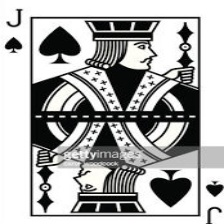

In [ ]:
image, label = dataset[3242]
image

In [ ]:
#Get a dictonary assositing target values with folder names
data_dir='/kaggle/input/cards-image-datasetclassification'
target_to_class={v: k for k, v in ImageFolder(data_dir).class_to_idx.items()}
print(target_to_class)

{0: 'test', 1: 'train', 2: 'valid'}


In [ ]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

data_dir = '/kaggle/input/cards-image-datasetclassification'
dataset = PlayingCardDataset(data_dir, transform)

In [ ]:
image, label = dataset[10]
image.shape

torch.Size([3, 128, 128])

In [ ]:
# iterate over dataset
for image, label in dataset:
    break

## Dataloaders

- Batching our dataset
- It's faster to train the model in batches instead of one at a time.

In [ ]:
dataloader = DataLoader(dataset, batch_size=32,  shuffle=True)

In [ ]:
for images, labels in dataloader:
    break

In [ ]:
images.shape, labels.shape

(torch.Size([32, 3, 128, 128]), torch.Size([32]))

In [ ]:
labels

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
        1, 1, 2, 1, 1, 1, 1, 1])

# Step 2. Pytorch Model

Pytorch datasets have a structured way of organizing your data, pytorch models follow a similar paradigm.
- We could create the model from scratch defining each layer.
- However for tasks like image classification, many of the state of the art architectures are readily available and we can import them from packages like timm.
- Understanding the pytorch model is all about understanding the shape the data is at each layer, and the main one we need to modify for a task is the final layer. Here we have 53 targets, so we will modify the last layer for this.


In [ ]:
class SimpleCardClassifer(nn.Module):
    def __init__(self, num_classes=53):
        super(SimpleCardClassifer, self).__init__()
        # Where we define all the parts of the model
        self.base_model = timm.create_model('efficientnet_b0', pretrained=True)
        self.features = nn.Sequential(*list(self.base_model.children())[:-1])

        enet_out_size = 1280
        # Make a classifier
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(enet_out_size, num_classes)
        )

    def forward(self, x):
        # Connect these parts and return the output
        x = self.features(x)
        output = self.classifier(x)
        return output

In [ ]:
model = SimpleCardClassifer(num_classes=53)
print(str(model)[:500])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

SimpleCardClassifer(
  (base_model): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=Fal


In [ ]:
exmaple_out = model(images)
exmaple_out.shape # [batch_size, num_classes]

torch.Size([32, 53])

# Step 3. The training loop

- Now that we understand the general paradigm of pytorch datasets and models, we need to create the process of training this model.
- Some things to consider: We want to validate our model on data it has not been trained on, so usually we split our data into a train and validate datasets (I have whole videos on this). This is easy because we can just create two datasets using our existing class.
    - Terms:
        - Epoch: One run through the entire training dataset.
        - Step: One batch of data as defined in our dataloader
- This loop is one you will become familiar with when training models, you load in data to the model in batches - then calculate the loss and perform backpropagation. There are packages that package this for you, but it's good to have at least written it once to understand how it works.
- Two things to select:
    - optimizer, `adam` is the best place to start for most tasks.
    - loss function: What the model will optimize for.


In [ ]:
# Loss function
criterion = nn.CrossEntropyLoss()
# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

# Update paths to point to the correct location in Kaggle
train_folder = '/kaggle/input/cards-image-datasetclassification/train'
valid_folder = '/kaggle/input/cards-image-datasetclassification/valid'
test_folder = '/kaggle/input/cards-image-datasetclassification/test'

train_dataset = PlayingCardDataset(train_folder, transform=transform)
valid_dataset = PlayingCardDataset(valid_folder, transform=transform)
test_dataset = PlayingCardDataset(test_folder, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Setup Datasets

In [ ]:
# Simple training loop
num_epochs = 20
train_losses, val_losses = [], []

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = SimpleCardClassifer(num_classes=53)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc='Training loop'):
        # Move inputs and labels to the device
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * labels.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validation phase
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in tqdm(valid_loader, desc='Validation loop'):
            # Move inputs and labels to the device
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)
    val_loss = running_loss / len(valid_loader.dataset)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} - Train loss: {train_loss}, Validation loss: {val_loss}")

Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 1/20 - Train loss: 1.4901177690511986, Validation loss: 0.4167875640797165


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 2/20 - Train loss: 0.5509917508705215, Validation loss: 0.2762914743063585


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 3/20 - Train loss: 0.3373447784378046, Validation loss: 0.1671267699520543


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 4/20 - Train loss: 0.2398276087463465, Validation loss: 0.2043016547864338


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 5/20 - Train loss: 0.19149844275527522, Validation loss: 0.10689908843838944


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 6/20 - Train loss: 0.15336949139020375, Validation loss: 0.169083789525167


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 7/20 - Train loss: 0.13077453042283763, Validation loss: 0.18939459773729433


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 8/20 - Train loss: 0.11345080989789207, Validation loss: 0.16920306705078988


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 9/20 - Train loss: 0.11989097342731632, Validation loss: 0.1381323946042443


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 10/20 - Train loss: 0.09052592868049866, Validation loss: 0.10085376371752541


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 11/20 - Train loss: 0.09395875441055092, Validation loss: 0.19439634760876873


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 12/20 - Train loss: 0.08668624470596752, Validation loss: 0.111164904765363


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 13/20 - Train loss: 0.10560462897465586, Validation loss: 0.178443358754212


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 14/20 - Train loss: 0.07688704872912369, Validation loss: 0.19740901971763036


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 15/20 - Train loss: 0.07875633378833696, Validation loss: 0.20649608640738254


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 16/20 - Train loss: 0.06847050650082412, Validation loss: 0.18349404509337444


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 17/20 - Train loss: 0.107494969028444, Validation loss: 0.17038533735387731


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 18/20 - Train loss: 0.08115664876198322, Validation loss: 0.07893711426910364


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 19/20 - Train loss: 0.054804732313072785, Validation loss: 0.09506106602713325


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 20/20 - Train loss: 0.05350230269342688, Validation loss: 0.088434975799876


## Simple Training Loop

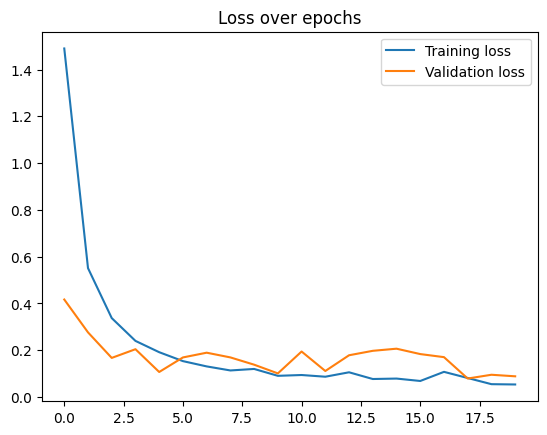

In [ ]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.title("Loss over epochs")
plt.show()

# Visualize Losses

We can plot our training and validation loss through this training, usually we do this at the end of each epoch. We see that our accuracy on the validation dataset is `x`! There are a LOT more things to learn about that can drastically improve how to train a model which I will cover in future videos, but this should give you a good start!



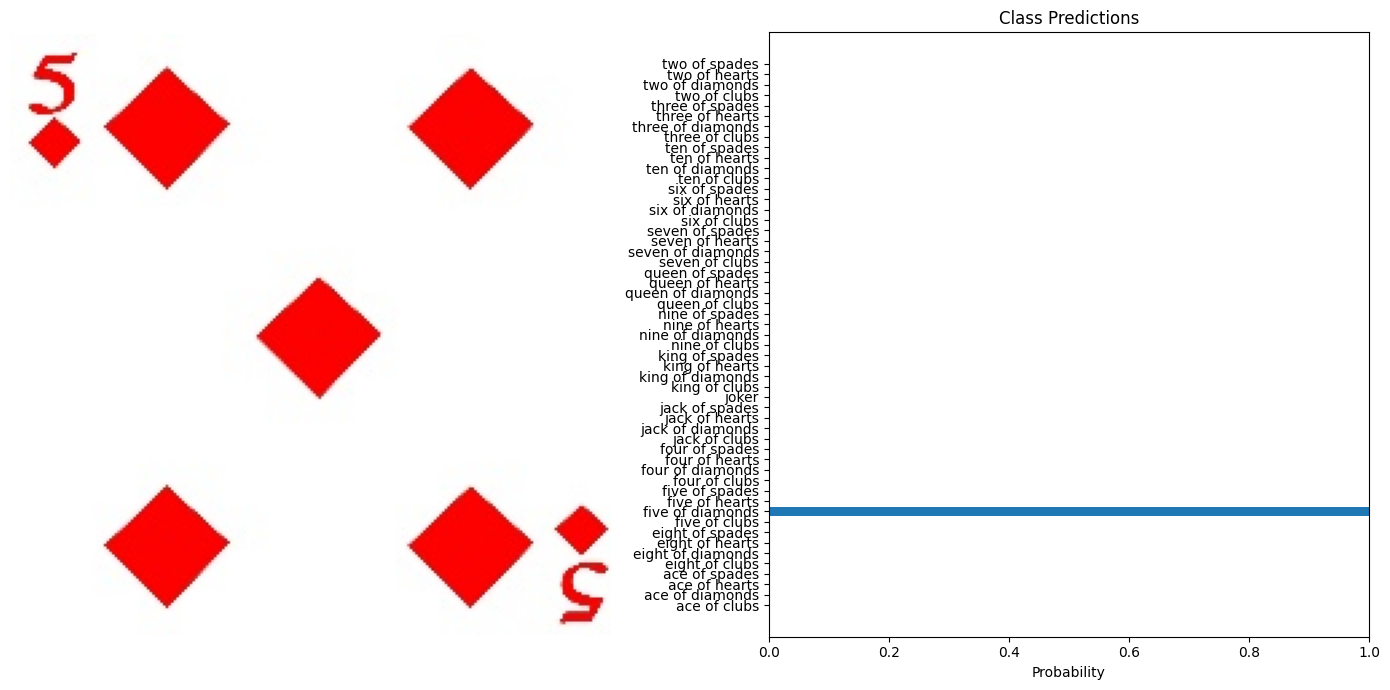

In [ ]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from torchvision.datasets import ImageFolder # Import ImageFolder for class names

# Load and preprocess the image
def preprocess_image(image_path, transform):
    image = Image.open(image_path).convert("RGB")
    return image, transform(image).unsqueeze(0)

# Predict using the model
def predict(model, image_tensor, device):
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
    return probabilities.cpu().numpy().flatten()

# Visualization
def visualize_predictions(original_image, probabilities, class_names):
    fig, axarr = plt.subplots(1, 2, figsize=(14, 7))

    # Display image
    axarr[0].imshow(original_image)
    axarr[0].axis("off")

    # Display predictions
    axarr[1].barh(class_names, probabilities) # Use class_names obtained from ImageFolder
    axarr[1].set_xlabel("Probability")
    axarr[1].set_title("Class Predictions")
    axarr[1].set_xlim(0, 1)

    plt.tight_layout()
    plt.show()

# Example usage
test_image = "/kaggle/input/cards-image-datasetclassification/test/five of diamonds/2.jpg"
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

original_image, image_tensor = preprocess_image(test_image, transform)
probabilities = predict(model, image_tensor, device)

# Get class names from the training dataset
data_dir = '/kaggle/input/cards-image-datasetclassification/train' # Path to your training data
class_names = ImageFolder(data_dir).classes # Get class names using ImageFolder

visualize_predictions(original_image, probabilities, class_names)

# **Bonus:** Evaluating the Results



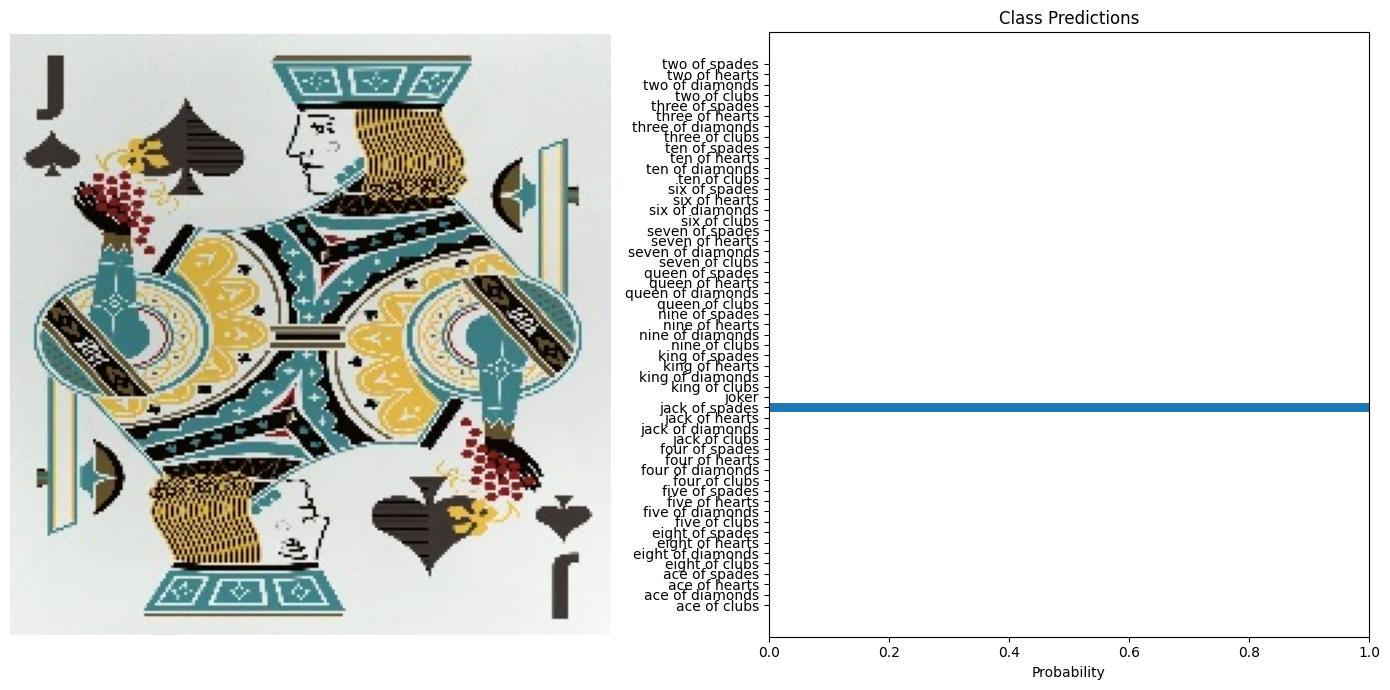

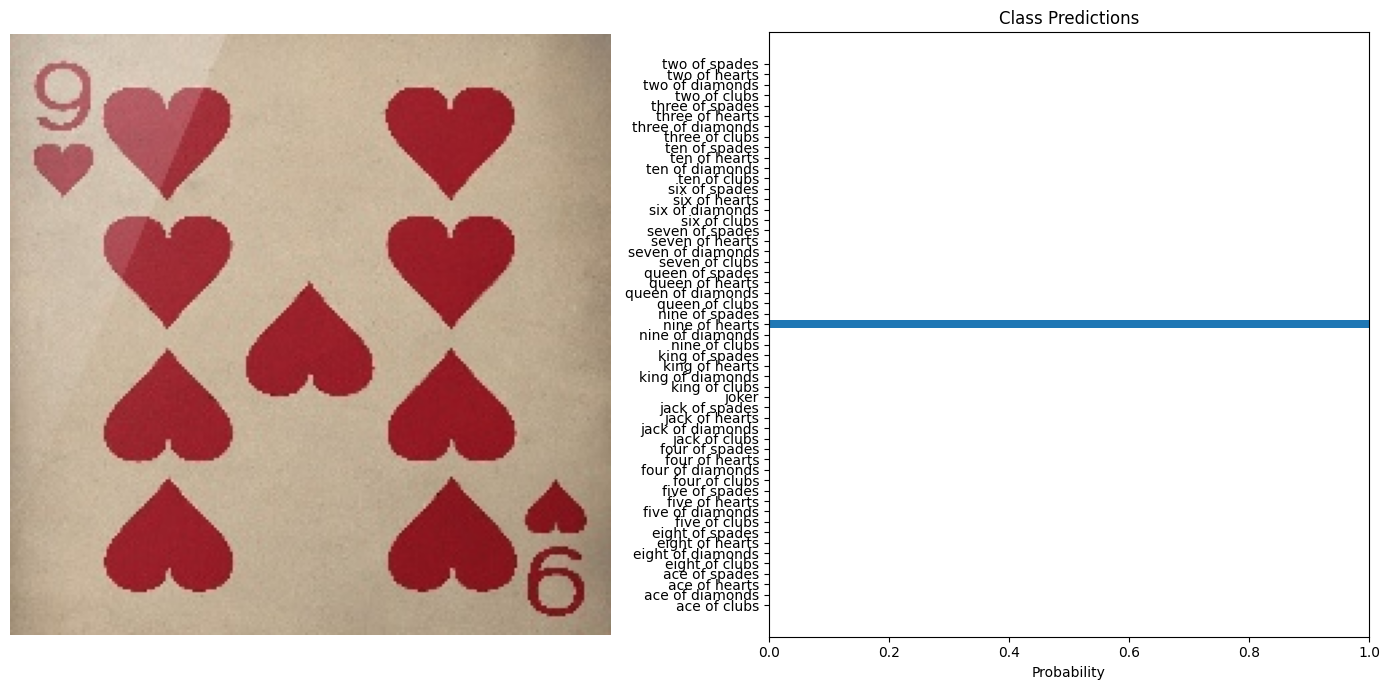

In [ ]:
from glob import glob
from torchvision.datasets import ImageFolder

test_images = glob('/kaggle/input/cards-image-datasetclassification/test/*/*') # Updated path
test_examples = np.random.choice(test_images, 2)

# Get class names from the training dataset (only once, outside the loop)
data_dir = '/kaggle/input/cards-image-datasetclassification/train'
class_names = ImageFolder(data_dir).classes

for example in test_examples:
    original_image, image_tensor = preprocess_image(example, transform)
    probabilities = predict(model, image_tensor, device)

    # Using the class names obtained earlier
    visualize_predictions(original_image, probabilities, class_names)

In [ ]:
# prompt: - Calculate the accuracy of our model on the validation and test set.

def calculate_accuracy(model, dataloader, device):
    model.eval()
    correct_predictions = 0
    total_predictions = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total_predictions += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()
    return correct_predictions / total_predictions

# Calculate accuracy on validation set
validation_accuracy = calculate_accuracy(model, valid_loader, device)
print(f"Validation Accuracy: {validation_accuracy}")

# Calculate accuracy on test set
test_accuracy = calculate_accuracy(model, test_loader, device)
print(f"Test Accuracy: {test_accuracy}")


Validation Accuracy: 0.9773584905660377
Test Accuracy: 0.9811320754716981


# Todo

- Calculate the accuracy of our model on the validation and test set.